In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

%cd ..

C:\Users\vujanicr\PycharmProjects\nsopy


## Example 2: solving dual problems

The main intended application of these methods is to solve dual problems. Unless the underlying primal problem is convex and has a strictly convex objective (or dualized constraints) the dual problem is non-smooth. This is for example the case for problems entailing discrete (e.g. binary) variables.

* Consider the following optimization program (MILP):
$$
\begin{array}{ll}
\min\limits_x     & -\frac{1}{2} x_1 - x_2 + x_3\\
\mathrm{s.t.}    & \frac{1}{2} x_1 + \frac{1}{2} x_2 + x_3 \geq 1\\
& x_1 + x_2 \leq 1\\
& 0 \leq x_1,x_2,x_3 \leq 1\\
& x_1 \in \left\{0,1\right\}.
\end{array}
$$


Without the first two constraints, the problem is trivial (linear optimization over a box). The general idea of duality is to take some advantage from this fact; in this framework "complicating" constraints are dualized in the objective and we solve the associated dual.

* We introduce the corresponding dual function $d(\lambda)$:

$$
\begin{array}{lcll}
d(\lambda) & = & \min\limits_x & -\frac{1}{2} x_1 - x_2 + x_3 + \lambda_1 (1 - \frac{1}{2} x_1 - \frac{1}{2} x_2 - x_3) + \lambda_2(x_1+x_2 -1)\\
&& \mathrm{s.t.} & 0 \leq x_1,x_2,x_3 \leq 1\\
&&& x_1 \in \left\{0,1\right\}. \\
\end{array}
$$

Notice how evaluating the dual function is trivial: the *inner* optimization problem simply sets to 0 variables that, for given $\lambda$, have a positive objective; otherwise 1. The dual function looks like this:
![dual function](img/ex_2.png)
This is the non-smooth function we would like to optimize (maximize) in the dual problem:

$$
\begin{array}{ll}
\max\limits_\lambda & d(\lambda) \\
\mathrm{s.t.} & \lambda \in \Lambda
\end{array}
$$

where $\Lambda = \mathbb{R}_+^2$. Notice that, in contrast to the previous example where the entire function was known analytically a priori, in this case we do not have an explicit analytical expression for $d(\lambda)$ but we can query its first order oracle.

This problem belongs to the battery of test cases, so we can simply import it and pass it to our solvers.

In [2]:
from tests.analytical_oracles import AnalyticalExampleInnerProblem
from methods.quasi_monotone_subgradient_methods import SGMDoubleSimpleAveraging as DSA
from methods.quasi_monotone_subgradient_methods import SGMTripleAveraging as TA
from methods.subgradient_methods import SubgradientMethod as SG
from methods.universal_gradient_methods import UniversalPGM as UPGM
from methods.universal_gradient_methods import UniversalDGM as UDGM
from methods.universal_gradient_methods import UniversalFGM as UFGM
from methods.method_loggers import GenericDualMethodLogger

In [3]:
inner_problem = AnalyticalExampleInnerProblem()
dual_method = UPGM(inner_problem.oracle, inner_problem.projection_function, epsilon=0.01)
method_logger = GenericDualMethodLogger(dual_method)

for iteration in range(60):
    dual_method.dual_step()

**Note 1**: you can try all the different methods. 
**Note 2**: we do not need to pass the `dimension` argument if the `projection_function()` method can be called with 0, and returns an initial point of appropriate dimension.

And plot the resulting method's trajectory:

<IPython.core.display.Javascript object>


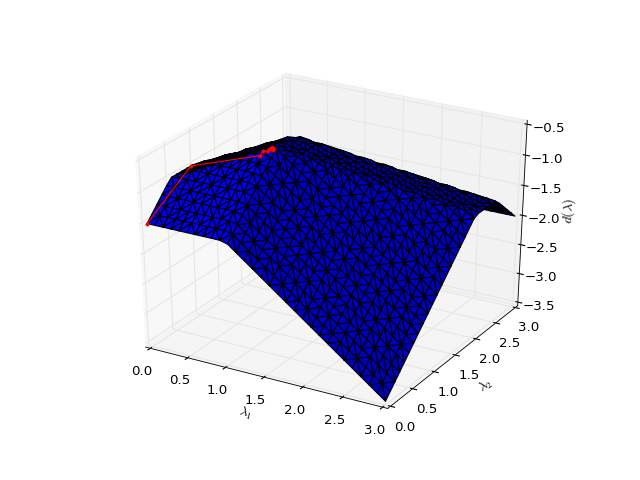

In [4]:
box = np.linspace(0, 3, 30)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array([lmd_1 for lmd_1 in box for lmd_2 in box]),
                np.array([lmd_2 for lmd_1 in box for lmd_2 in box]),
                np.array([inner_problem.oracle(np.array([lmd_1, lmd_2]))[1] for lmd_1 in box for lmd_2 in box]))
ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
ax.set_zlabel('$d(\lambda)$')

plt.plot([lmd[0] for lmd in method_logger.lambda_k_iterates],
         [lmd[1] for lmd in method_logger.lambda_k_iterates],
         [d_lmd for d_lmd in method_logger.d_k_iterates], 'r.-')